In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

## Result Gathering

In [2]:
main_df = None
directory = "Effort_Estimation_Results_v3/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cxf.csv
Dbeaver.csv
Hadoop.csv
Okhttp.csv
Redisson.csv


In [3]:
main_df.head()

,sha,name,email,date,login,message,parent_sha,parent_date,time_taken,contains_refactoring,...,num_dependency_max,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std
0,6ad1e4fe77445e8689f6d3975b26e52165c9c3e6,Bin Fan,fanbin103@gmail.com,2021-08-04 02:49:16,apc999,Fix IndexOutOfBoundsException on async cache\n...,df5dcab8bc308dfd2bf650a895865b13120a9866,2021-08-03 16:07:28,10.0,1,...,322.0,NaN,764.000000,764,764,NaN,9.0,9,9,NaN
1,8647c6162423b851dda8d10edf4686473d2e95cc,Zac Blanco,zac@alluxio.com,2021-07-15 21:54:27,ZacBlanco,Update and improve conformance of S3 API\n\n##...,79a5e5c78b7dfcdbf8edbd928a2ff59c904d08f8,2021-07-15 18:38:50,3.0,1,...,15.0,NaN,275.000000,275,275,NaN,6.0,6,6,NaN
2,3ce52983e6f50bfb7880b5a2cb13a18e4272170b,Zhan Yuan,yuanzhanhku@gmail.com,2021-07-12 06:39:42,yuanzhanhku,Add CacheContext to URIStatus to enable per-re...,cf79c7837c57c83c1b99a1dab53fec25deb2069d,2021-07-10 20:58:13,33.0,1,...,371.0,0.000000,115.000000,115,115,0.000,4.5,3,6,2.121320
3,a4dc54f7dc0333da096aa779dbaa79060c90d1ad,kqhzz,kuangqinghuazz@163.com,2021-06-09 18:09:26,kuszz,Deprecate leader command\n\nFix #13512\n\npr-l...,1356c0b35fd753d1081665b2c8f6b25da62bf2e8,2021-06-09 02:31:45,15.0,1,...,85.0,NaN,61.000000,61,61,NaN,2.0,2,2,NaN
4,7fb84094a6075bcef5a103b40adcac4b26b724ca,Jiacheng Liu,jiacheliu3@gmail.com,2021-05-29 00:37:05,jiacheliu3,Refactor MasterWorkerInfo\n\nCurrently all the...,220237085593d731756e24249bcf88a4d6ea5710,2021-05-28 23:28:46,1.0,1,...,177.0,93.543216,458.666667,24,1245,682.248,35.0,1,54,29.512709


In [4]:
len(main_df)

366

In [5]:
def get_final_time_taken(row):
    if row['time_taken'] > row['mean']:
        return row['time_taken'] - row['mean']
    else:
        return row['time_taken']
        #if (row['time_taken'] - row['min']) == 0:
        #    return 1
        #else:
        #    return row['time_taken'] - row['min']

In [6]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [7]:
#main_df = main_df[main_df['time_taken_final'] > 1]

In [8]:
main_df['time_taken_final'].value_counts()

1.000000     68
2.000000     32
3.000000     31
4.000000     18
8.000000     10
             ..
24.870690     1
21.169082     1
0.186047      1
8.566667      1
24.196653     1
Name: time_taken_final, Length: 143, dtype: int64

In [9]:
main_df = main_df.fillna(0)

In [10]:
main_df

,sha,name,email,date,login,message,parent_sha,parent_date,time_taken,contains_refactoring,...,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,time_taken_final
0,6ad1e4fe77445e8689f6d3975b26e52165c9c3e6,Bin Fan,fanbin103@gmail.com,2021-08-04 02:49:16,apc999,Fix IndexOutOfBoundsException on async cache\n...,df5dcab8bc308dfd2bf650a895865b13120a9866,2021-08-03 16:07:28,10.0,1,...,0.000000,764.000000,764,764,0.000000,9.0,9,9,0.000000,10.000000
1,8647c6162423b851dda8d10edf4686473d2e95cc,Zac Blanco,zac@alluxio.com,2021-07-15 21:54:27,ZacBlanco,Update and improve conformance of S3 API\n\n##...,79a5e5c78b7dfcdbf8edbd928a2ff59c904d08f8,2021-07-15 18:38:50,3.0,1,...,0.000000,275.000000,275,275,0.000000,6.0,6,6,0.000000,3.000000
2,3ce52983e6f50bfb7880b5a2cb13a18e4272170b,Zhan Yuan,yuanzhanhku@gmail.com,2021-07-12 06:39:42,yuanzhanhku,Add CacheContext to URIStatus to enable per-re...,cf79c7837c57c83c1b99a1dab53fec25deb2069d,2021-07-10 20:58:13,33.0,1,...,0.000000,115.000000,115,115,0.000000,4.5,3,6,2.121320,33.000000
3,a4dc54f7dc0333da096aa779dbaa79060c90d1ad,kqhzz,kuangqinghuazz@163.com,2021-06-09 18:09:26,kuszz,Deprecate leader command\n\nFix #13512\n\npr-l...,1356c0b35fd753d1081665b2c8f6b25da62bf2e8,2021-06-09 02:31:45,15.0,1,...,0.000000,61.000000,61,61,0.000000,2.0,2,2,0.000000,15.000000
4,7fb84094a6075bcef5a103b40adcac4b26b724ca,Jiacheng Liu,jiacheliu3@gmail.com,2021-05-29 00:37:05,jiacheliu3,Refactor MasterWorkerInfo\n\nCurrently all the...,220237085593d731756e24249bcf88a4d6ea5710,2021-05-28 23:28:46,1.0,1,...,93.543216,458.666667,24,1245,682.248000,35.0,1,54,29.512709,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,f8065acac28a0b86f3bdbd854ac87af0789416d0,Jesse Wilson,jesse@swank.ca,2020-10-30 06:59:02,swankjesse,Execute CallTest with JUnit 5 (#6349)\n\n* Exe...,f1bc9d1d3339d0696e232a5d8a2d7830630a8242,2020-10-24 04:03:17,146.0,1,...,0.000000,3932.000000,3932,3932,0.000000,2.0,2,2,0.000000,123.541667
6,3e331c108905a97fa9718b40844ddc1356fc86b5,Jesse Wilson,jesse@swank.ca,2020-10-18 12:13:09,swankjesse,Rename okhttp3.mockwebserver to mockwebserver3...,02ac2f38e8f8dacebb090dcf7f7eb30ed29d4fc7,2020-10-18 11:02:17,1.0,1,...,137.772068,217.500000,67,566,217.340418,4.5,1,8,2.449490,1.000000
7,334eb0072512155e57a809b2fa18861c0d68ec9f,Jesse Wilson,jesse@swank.ca,2020-10-02 01:46:58,swankjesse,Rename okhttp3.internal.sse to okhttp3.sse.int...,480c20e46bb1745e280e42607bbcc73b2c953d97,2020-10-02 00:07:44,1.0,1,...,58.052849,117.500000,31,198,61.085732,4.5,1,8,2.366432,1.000000
0,d1eb2ece8f9ddb4cc797fd236cc4462682372ef8,jackygurui,jackygurui@gmail.com,2016-09-08 22:59:19,jackygurui,Renamed ExpirableInterceptor to RExpirableInte...,552eb98012897cdefd1a70231eef040e1ee6abe9,2016-09-08 21:11:34,1.0,1,...,0.000000,18.000000,18,18,0.000000,1.0,1,1,0.000000,1.000000


In [11]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [12]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

### Only taking mean for num_dependency and num_line_affected since there is only one

In [25]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','mean',
'min','max',
'project_name','commit_compared_with','actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
                 'num_dependency_min',
                  'num_dependency_max',
                  'num_dependency_std',
                 'num_line_affected_min',
                 'num_line_affected_max',
                 'num_line_affected_std']
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [26]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [27]:
X_col = final_col.copy()
X_col.remove('time_taken_final')
Y_col = ['time_taken_final']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [28]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,38.000000,38.0,38.0,0.000000,57.0,57.0,57.0,0.000000,1.000000,1.0,...,279.0,279.0,279.0,0.000000,17.0,17.0,17.0,0.0,322.000000,764.000000
1,12.000000,12.0,12.0,0.000000,17.0,17.0,17.0,0.000000,1.000000,1.0,...,115.0,115.0,115.0,0.000000,1.0,1.0,1.0,0.0,15.000000,275.000000
2,4.000000,4.0,4.0,0.000000,15.0,15.0,15.0,0.000000,1.000000,1.0,...,108.0,108.0,108.0,0.000000,1.0,1.0,1.0,0.0,371.000000,115.000000
3,11.000000,11.0,11.0,0.000000,8.0,8.0,8.0,0.000000,2.000000,2.0,...,58.0,58.0,58.0,0.000000,17.0,17.0,17.0,0.0,85.000000,61.000000
4,27.666667,3.0,76.0,41.860881,50.0,1.0,140.0,78.044859,1.666667,1.0,...,175.0,36.0,407.0,202.230067,1.0,1.0,1.0,0.0,69.333333,458.666667


In [29]:
y.head()

,time_taken_final
0,10.0
1,3.0
2,33.0
3,15.0
4,1.0


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [31]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,25 mins 39 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,2 months and 22 days
H2O_cluster_name:,H2O_from_python_tanji_luj4gp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.983 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [32]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "time_taken_final"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [44]:
train[y].types

{'time_taken_final': 'real'}

In [47]:
aml = H2OAutoML(max_models=25, seed=16, exclude_algos=['XGBoost'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpgmr7rne7.csv'
███████████████████████████████████████████████████████| 100%


In [48]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20211125_154317_model_2,774.718,27.8338,774.718,17.7338,1.35116
StackedEnsemble_BestOfFamily_AutoML_20211125_154317,778.697,27.9051,778.697,17.8871,nan
StackedEnsemble_AllModels_AutoML_20211125_154317,784.795,28.0142,784.795,17.9306,nan
GBM_grid__1_AutoML_20211125_154317_model_8,791.022,28.1251,791.022,18.3107,1.39806
GBM_5_AutoML_20211125_154317,799.894,28.2824,799.894,18.3931,1.4057
GBM_grid__1_AutoML_20211125_154317_model_3,801.392,28.3089,801.392,18.2027,1.39506
GLM_1_AutoML_20211125_154317,801.695,28.3142,801.695,18.4806,nan
DeepLearning_grid__2_AutoML_20211125_154317_model_3,809.957,28.4597,809.957,16.7741,nan
DeepLearning_grid__3_AutoML_20211125_154317_model_2,818.607,28.6113,818.607,18.5828,nan
GBM_grid__1_AutoML_20211125_154317_model_1,826.554,28.7499,826.554,18.7258,1.40764


In [49]:
model = h2o.get_model(lb[0,'model_id'])

In [50]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20211125_154317_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,32.0,32.0,5708.0,4.0,7.0,5.09375,8.0,11.0,9.5625




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 405.3148218029351
RMSE: 20.132432088620966
MAE: 12.804343096794575
RMSLE: 1.0783716149070952
Mean Residual Deviance: 405.3148218029351

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 774.7178920351772
RMSE: 27.833754544350953
MAE: 17.73376221538167
RMSLE: 1.351159632768024
Mean Residual Deviance: 774.7178920351772

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,17.733246,2.62976,15.905257,20.52345,20.161343,14.473959,17.602222
1,mean_residual_deviance,774.1871,231.38574,676.3586,1001.3473,1036.5414,517.3253,639.3629
2,mse,774.1871,231.38574,676.3586,1001.3473,1036.5414,517.3253,639.3629
3,r2,0.0642258,0.08141673,0.18830448,0.03161784,-0.03426504,0.054874003,0.080597706
4,residual_deviance,774.1871,231.38574,676.3586,1001.3473,1036.5414,517.3253,639.3629
5,rmse,27.575348,4.1513925,26.006895,31.644072,32.195362,22.744787,25.285625
6,rmsle,1.3447012,0.15235972,1.1728806,1.5456296,1.2907313,1.2577902,1.4564738



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-25 15:43:30,0.452 sec,0.0,28.752018,18.874668,826.678565
1,,2021-11-25 15:43:30,0.465 sec,5.0,26.585931,17.322934,706.811735
2,,2021-11-25 15:43:30,0.476 sec,10.0,24.841521,15.936852,617.101188
3,,2021-11-25 15:43:30,0.488 sec,15.0,23.614126,14.970778,557.626950
4,,2021-11-25 15:43:30,0.500 sec,20.0,22.418451,14.205937,502.586924
5,,2021-11-25 15:43:30,0.511 sec,25.0,21.485113,13.598172,461.610088
6,,2021-11-25 15:43:30,0.523 sec,30.0,20.407646,13.015390,416.472033
7,,2021-11-25 15:43:30,0.529 sec,32.0,20.132432,12.804343,405.314822



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,totalFields_mean,36759.464844,1.000000,0.061806
1,wmc_mean,33209.566406,0.903429,0.055837
2,maxNestedBlocks_max,33071.519531,0.899674,0.055605
3,uniqueWordsQty_mean,24833.539062,0.675569,0.041754
4,rfc_mean,23301.345703,0.633887,0.039178
5,returnQty_mean,23211.544922,0.631444,0.039027
6,totalMethods_std,20295.273438,0.552110,0.034124
7,totalMethods_mean,20284.013672,0.551804,0.034105
8,variablesQty_mean,17092.384766,0.464979,0.028739
9,num_dependency_mean,16773.087891,0.456293,0.028202



See the whole table with table.as_data_frame()


In [51]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [52]:
preds

predict
7.91942
8.59107
0.941594
14.6032
9.708
35.7014
42.6651
42.6651
20.9833
31.0617


In [53]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

42.665128    2
16.478501    2
56.245926    2
14.997491    1
13.146957    1
            ..
4.812459     1
18.870325    1
2.640765     1
17.417302    1
14.709571    1
Name: predict, Length: 109, dtype: int64

In [54]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

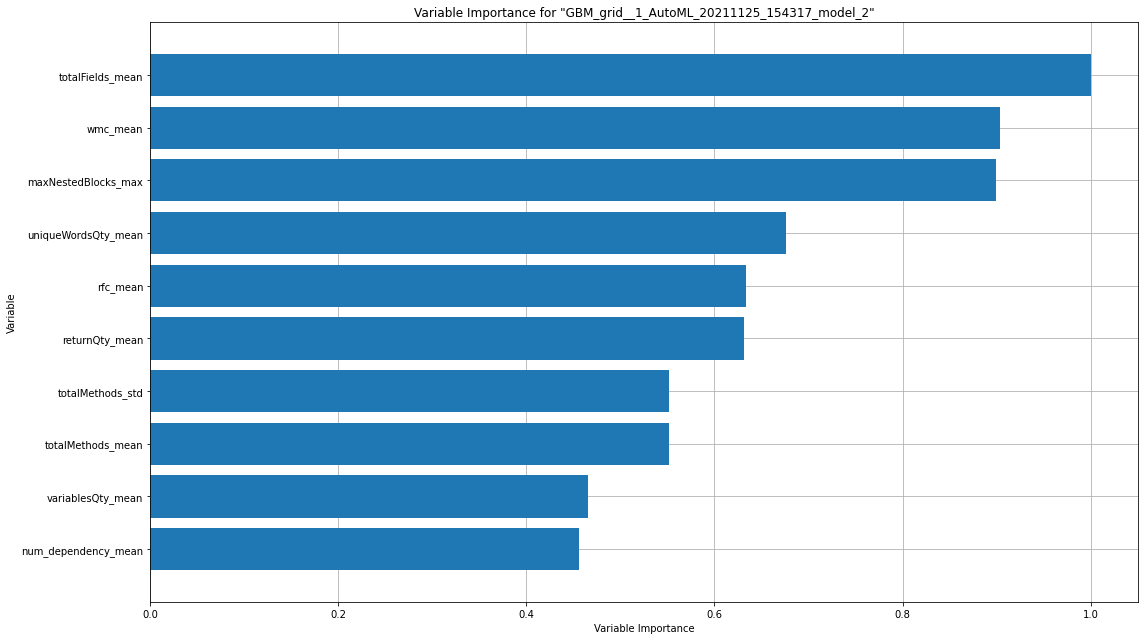

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

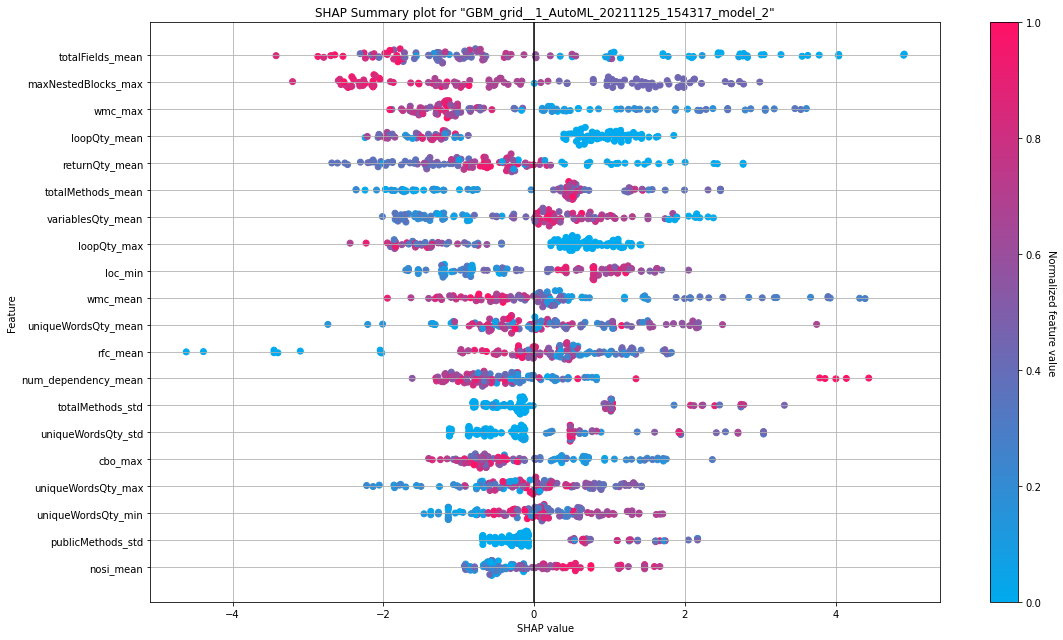

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

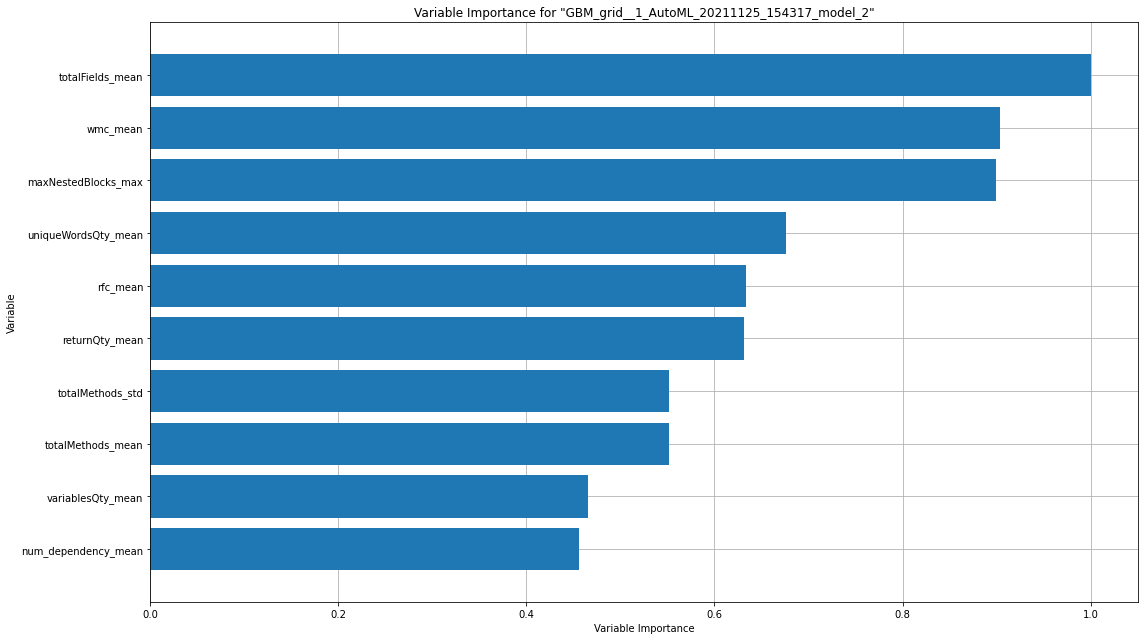

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

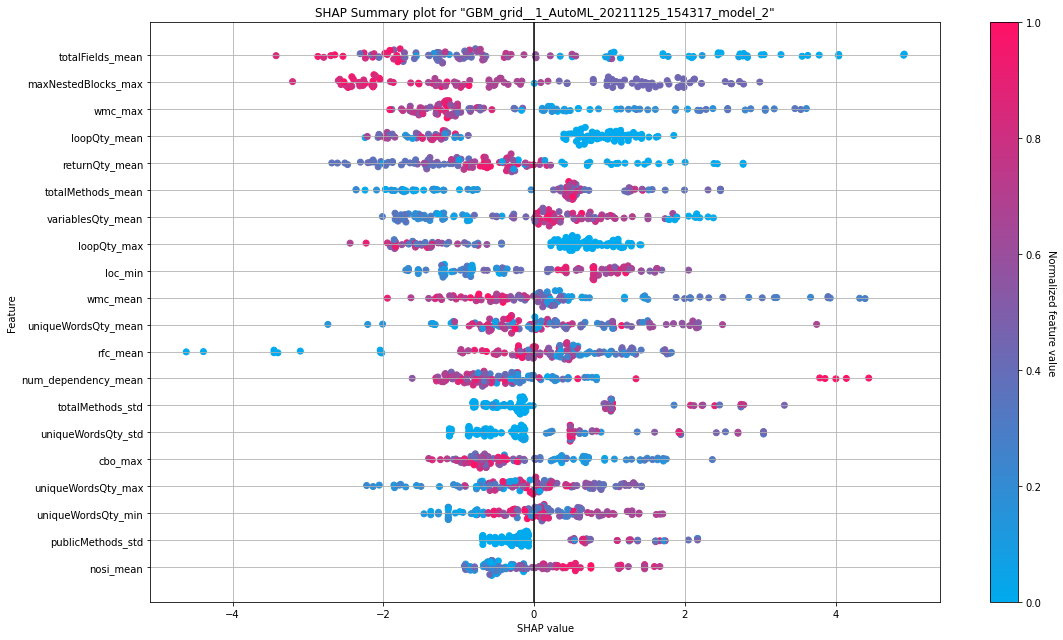

In [62]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [65]:
#aml.explain_row(test, row_index=0)

In [66]:
#h2o.shutdown()